In [2]:
import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Common_Functions as cf 
from mpl_toolkits import mplot3d
plt.rc('font', family='serif')
import matplotlib
matplotlib.rcParams.update({'legend.fontsize': 16})
matplotlib.rcParams.update({'font.size': 16})

In [14]:
#Load Data
df_pions = np.array(pd.read_csv('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/testing_data.csv',header = None))
#Hold Out Validation
train_x, train_y = df_pions[:-1000,:-1], df_pions[:-1000,-1]
val_x, val_y = df_pions[-1000:,:-1], df_pions[-1000:,-1]

In [15]:
#Adam Optimiser
opt = keras.optimizers.Adam( amsgrad= True)

In [18]:
## Function Creates multiple Identical networks while varying batch size.
## Returns numpy array of Batch sizes 
## Returns numpy array of min MAPE of size len(batch_size),repeats
def batch_size_tester(batch_size_range,step = 2,repeats = 5,section = None):
    
    batch_size_min, batch_size_max = batch_size_range
    batch_size_max = batch_size_max+1 ##Indexing trick so that the last batch size value is included 
    batch_sizes = np.arange(batch_size_min,batch_size_max,step = step)
    is_last_val_bool = np.zeros_like(batch_sizes)
    min_mape = np.zeros((len(batch_sizes),repeats))
    for i,_ in enumerate(batch_sizes):
        print('Batch Size ',batch_sizes[i])
        last_val_bool = 0
        for j in range(repeats):
            mape_df = cf.trained_network(train_x[:section],train_y[:section],val_x,val_y,[512,512,512], optimizer= opt, verbose= 1,batch_size = batch_sizes[i]).history
            val_mape_ar_smoothed = cf.exponetial_smoothing(np.array(mape_df['val_mean_absolute_percentage_error']),0.4)
            loss_ar_smoothed = cf.exponetial_smoothing(np.array(mape_df['loss']),0.4)
            min_mape[i,j] = np.min(val_mape_ar_smoothed)
            if cf.neg_grad_tester(val_mape_ar_smoothed,loss_ar_smoothed):
                last_val_bool +=1
                print('Negative Grad Identified')
            else:
                pass
                
                
        if last_val_bool >= 2:
            is_last_val_bool[i] = 1
        else:
            is_last_val_bool[i] = 0
    return min_mape, batch_sizes, last_val_bool

In [19]:
min_mape, batch_sizes , last_val_bool = batch_size_tester((4,4),step = 16, repeats= 10)

Batch Size  4
Epoch 1/30
24750/24750 [==============================] - 25s 1000us/step - loss: 63.6305 - mean_absolute_error: 0.0896 - mean_absolute_percentage_error: 63.6305 - val_loss: 67.0013 - val_mean_absolute_error: 0.0805 - val_mean_absolute_percentage_error: 67.0013
Epoch 2/30
24750/24750 [==============================] - 25s 1ms/step - loss: 61.3176 - mean_absolute_error: 0.0881 - mean_absolute_percentage_error: 61.3176 - val_loss: 66.1169 - val_mean_absolute_error: 0.0863 - val_mean_absolute_percentage_error: 66.1169
Epoch 3/30
24750/24750 [==============================] - 25s 1ms/step - loss: 31.8780 - mean_absolute_error: 0.0406 - mean_absolute_percentage_error: 31.8780 - val_loss: 14.0232 - val_mean_absolute_error: 0.0135 - val_mean_absolute_percentage_error: 14.0232
Epoch 4/30
24750/24750 [==============================] - 25s 1ms/step - loss: 12.1150 - mean_absolute_error: 0.0139 - mean_absolute_percentage_error: 12.1150 - val_loss: 16.5777 - val_mean_absolute_error: 

KeyboardInterrupt: 

In [4]:

##For very low batch sizes some networks dont converge
##This removes them, they are set to the mean plus one std some kind of average bad point
def clean_min_mape(min_mape):
    orig_min = min_mape.copy()
    mean_min_mape = np.mean(min_mape,axis =1 )
    mean_min_mape_array = (np.ones_like(min_mape).transpose()*mean_min_mape).transpose()
    std = np.std(min_mape,axis = 1)
    mean_plus_1_sigma = mean_min_mape+std
    mean_plus_1_sigma_array = (np.ones_like(min_mape).transpose()*mean_plus_1_sigma).transpose()
    #print(mean_plus_1_sigma_array)
    index = np.where(min_mape> mean_plus_1_sigma_array)
    min_mape[index] = mean_min_mape_array[index]

    return min_mape
cleaned_min_mape = clean_min_mape(min_mape)
#print(clean_mean)
clean_mean = np.mean(cleaned_min_mape,axis=1)
clean_ste = np.std(cleaned_min_mape,axis = 1)/10**0.5
print(min_mape[0,:])

[4.77797675 4.74349409 4.87811918 5.02811595 5.02811595 4.70297632
 4.60544568 5.02811595 5.02811595 4.95607957]


In [4]:
#print(last_val_bool)
#Calculation of plotting quantities
#np.savetxt('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Sean_Working_Notebooks/Testing_Notebooks/batch_size.csv',min_mape)
#np.savetxt('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Sean_Working_Notebooks/Testing_Notebooks/batch_size_bool.csv',last_val_bool)
min_mape = np.loadtxt('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Sean_Working_Notebooks/Testing_Notebooks/Testing_Data/bs/batch_size.csv')
last_val_bool = np.loadtxt('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Sean_Working_Notebooks/Testing_Notebooks/Testing_Data/bs/batch_size_bool.csv')
batch_sizes = np.arange(4,501,step = 16)

mean_min_mape = np.mean(min_mape,axis= 1)
std_min_mape = np.std(min_mape,axis= 1)
mse = std_min_mape/min_mape.shape[1]**0.5
print(batch_sizes.shape)
#print(clean_mean.shape)
print(min_mape)

(32,)
[[4.77797675 4.74349409 4.87811918 5.02811595 5.02811595 4.70297632
  4.60544568 5.02811595 5.02811595 4.95607957]
 [3.96345186 3.94170315 4.23593264 4.12852563 4.1878972  4.26917983
  4.14455592 4.21161185 3.86453108 4.1878972 ]
 [4.01516223 3.77458171 3.88339115 3.97035159 3.95016659 3.97035159
  4.01516223 3.97930148 3.94064416 4.01516223]
 [4.24851252 4.12569213 4.21864885 4.18555486 3.92127305 4.25620106
  4.21864885 4.18110872 4.16482501 3.99284523]
 [3.92401936 4.18445635 4.1334845  4.06895223 4.17515766 3.8905361
  4.18445635 4.12062857 4.13990381 4.12062857]
 [4.48637486 4.50247584 4.20435845 4.43601335 4.50247584 4.46355402
  4.35462807 4.48839696 4.36190549 4.46355402]
 [4.8907665  4.81253264 4.65328689 4.77329411 4.31841501 4.61202251
  4.8907665  4.90441206 4.78771507 4.78771507]
 [4.68571995 4.55774297 4.61336648 4.65632205 4.61336648 4.52052206
  4.68952585 4.30983072 4.65632205 4.34347264]
 [4.41952735 4.6596249  4.68319775 4.34376512 4.52352451 4.64252949
  4.606

In [9]:
batch_sizes[np.argmin(mean_min_mape)]

36

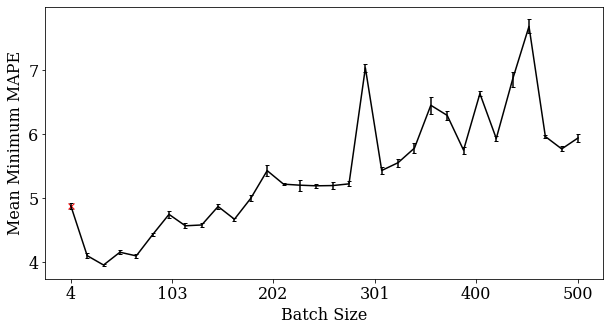

In [10]:
#plotting
fig, ax = plt.subplots(1,1, figsize= (10,5))
#ax = fig.add_axes((0,0,1,1))
ax.errorbar(batch_sizes,clean_mean,clean_ste,color = 'black',capsize= 2)
ax.plot(4,clean_mean[0],marker = 'x', linestyle = '', c = 'red')
ax.set_xlabel('Batch Size')
ax.set_ylabel('Mean Minimum MAPE')
ax.set_xticklabels(np.linspace(4,500,6,dtype= int))
ax.set_xticks(np.linspace(4,500,6,dtype= int))


In [11]:
fig.savefig('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Figures/Batch_size_2.png',dpi = 300, transparent= False)